From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers, optimizers, losses, models
#import tensorflow_datasets as tfds

In [2]:
import ffmpeg
from pydub import AudioSegment

In [3]:
from tf_helpers import *

In [4]:
from data_set_params import DataSetParams
from scipy.io import wavfile
params = DataSetParams()

In [5]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'richfield_birds_split'#'dublin_dl_birds_split'#
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [6]:
#AudioSegment.ffprobe  = "/usr/local/bin/ffmpeg"

In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#filenames = tf.io.gfile.glob('birds/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)

In [9]:
filenames

<tf.Tensor: shape=(2840,), dtype=string, numpy=
array([b'richfield_birds_split\\Northern Lapwing\\xc652090_start_0_0.wav',
       b'richfield_birds_split\\Mute Swan\\xc640258_left_start_3_30.wav',
       b'richfield_birds_split\\European Robin\\xc678277_left_start_10_15.wav',
       ..., b'richfield_birds_split\\Rook\\xc674819_start_0_0.wav',
       b'richfield_birds_split\\Common Kestrel\\xc608722_left_start_0_0.wav',
       b'richfield_birds_split\\Common Snipe\\xc675105_left_start_4_15.wav'],
      dtype=object)>

In [10]:
all_labs = [get_label(y).numpy().decode() for y in filenames]

In [11]:
filename_df = pd.DataFrame({'name': filenames.numpy(),
                            'label': all_labs
                           })

In [12]:
filename_df

,name,label
0,b'richfield_birds_split\\Northern Lapwing\\xc6...,Northern Lapwing
1,b'richfield_birds_split\\Mute Swan\\xc640258_l...,Mute Swan
2,b'richfield_birds_split\\European Robin\\xc678...,European Robin
3,b'richfield_birds_split\\Meadow Pipit\\xc59596...,Meadow Pipit
4,b'richfield_birds_split\\Common Kestrel\\xc672...,Common Kestrel
...,...,...
2835,b'richfield_birds_split\\Meadow Pipit\\xc66682...,Meadow Pipit
2836,b'richfield_birds_split\\European Herring Gull...,European Herring Gull
2837,b'richfield_birds_split\\Rook\\xc674819_start_...,Rook
2838,b'richfield_birds_split\\Common Kestrel\\xc608...,Common Kestrel


In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filename_df, test_size=0.2, stratify=filename_df[['label']])

In [14]:
#TRAIN_SIZE = 0.8

#cutoff = int(len(filenames) * TRAIN_SIZE)
#train_files = filenames[:cutoff]
#test_files  = filenames[cutoff:]
train_files = tf.random.shuffle(train['name'])
test_files  = tf.random.shuffle(test['name'])

print('Training set size:', len(train_files))
print('Validation set size:', len(test_files))

Training set size: 2272
Validation set size: 568


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
audio, sr = tf.audio.decode_wav(tf.io.read_file(train_files[0].numpy()))
sr

<tf.Tensor: shape=(), dtype=int32, numpy=44100>

In [17]:
#import tensorflow as tf
#from tensorflow.keras.layers import Concatenate

In [18]:
train_labs = [tf.argmax(get_label(y) == categories) for y in train_files]
test_labs  = [tf.argmax(get_label(y) == categories) for y in test_files]

In [19]:
train_labs_sort = train_labs
test_labs_sort  = test_labs
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

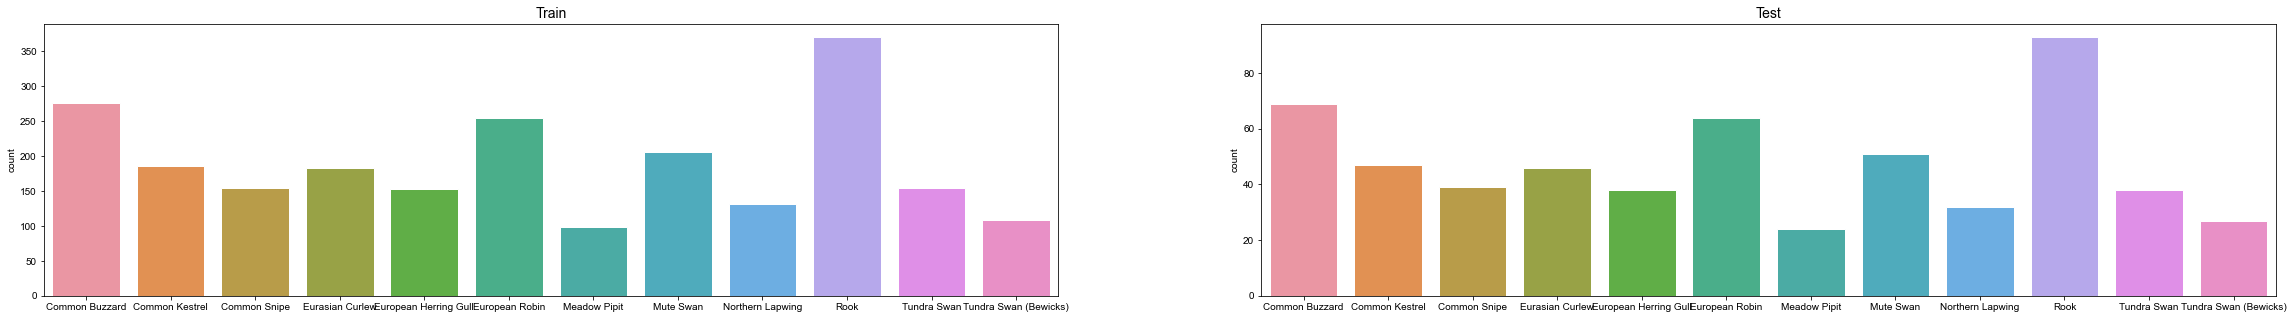

In [20]:
f, axes = plt.subplots(1, 2, figsize = (40,5))
l = []
for i in train_labs_sort:
    l.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = l, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=8)
axes[0].set_title("Train", size = 14)

lt = []
for i in test_labs_sort:
    lt.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = lt, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=10)
axes[1].set_title("Test", size = 14)

In [21]:
num_labels = len(categories)

In [22]:
choices = ['AbsRe', 'AbsIm', 'Mod', 'AbsAng']

In [23]:
train_ds_mult = preprocess_dataset(train_files, choices, categories, req_width=750)
test_ds_mult  = preprocess_dataset(test_files,  choices, categories, req_width=750)

In [24]:
for spec, lab in train_ds_mult.take(1):
    spec = spec
    input_shape = tf.expand_dims(spec[:,:,0], axis=-1).shape
    #input_shape = spec[:,:,0].shape
    print(input_shape)
    print(categories[lab])

(512, 750, 1)
European Robin


In [25]:
#tmp_spec = tf.stack(spec)
#spec
#tf.data.Dataset.zip(tuple(tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp))
#tuple([1,2,3])
#tmp_spec = tf.unstack(tmp_spec, axis=-1)
#tmp_spec = [tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp]
#tmp_spec

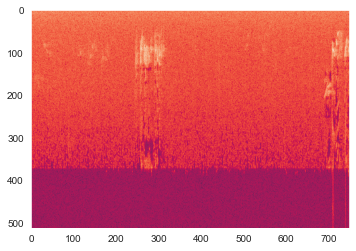

In [26]:
plt.imshow(np.log(spec[:,:,0]))
plt.grid(False)

In [27]:
y_train = np.array([y for x,y in train_ds_mult])
y_test  = np.array([y for x,y in test_ds_mult])
#y_train = train_labs
#y_test  = test_labs

In [28]:
x_tmp  = [x for x,y in train_ds_mult]
x_tmp  = tf.stack(x_tmp)
xs_tmp = tf.unstack(x_tmp, axis=-1)
xs_tmp = [tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp]

In [29]:
x_tmp_test  = [x for x,y in test_ds_mult]
x_tmp_test  = tf.stack(x_tmp_test)
xs_tmp_test = tf.unstack(x_tmp_test, axis=-1)
xs_tmp_test = [tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp_test]

In [30]:
num_channels = len(xs_tmp)

In [31]:
input_shape

TensorShape([512, 750, 1])

In [32]:
xs_tmp_test[0].shape[1:]

TensorShape([512, 750, 1])

In [33]:
model = concat_model(input_shape, num_channels = len(xs_tmp), num_classes = len(categories))

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 750, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 750, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512, 750, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512, 750, 1) 0                                            
______________________________________________________________________________________________

In [35]:
history = model.fit(xs_tmp, y_train,
                    validation_data = (xs_tmp_test, y_test),
                    epochs          = 10,
                    batch_size      = 32)

Epoch 1/10
71/71 [==============================] - 54s 739ms/step - loss: 2.5210 - accuracy: 0.1893 - val_loss: 2.2709 - val_accuracy: 0.2993
Epoch 2/10
71/71 [==============================] - 44s 627ms/step - loss: 2.2738 - accuracy: 0.2786 - val_loss: 2.0865 - val_accuracy: 0.3345
Epoch 3/10
71/71 [==============================] - 43s 610ms/step - loss: 2.1200 - accuracy: 0.3231 - val_loss: 1.9535 - val_accuracy: 0.3873
Epoch 4/10
71/71 [==============================] - 49s 690ms/step - loss: 1.9970 - accuracy: 0.3724 - val_loss: 1.8357 - val_accuracy: 0.4771
Epoch 5/10
71/71 [==============================] - 44s 622ms/step - loss: 1.8973 - accuracy: 0.4115 - val_loss: 1.7437 - val_accuracy: 0.4965
Epoch 6/10
71/71 [==============================] - 50s 703ms/step - loss: 1.8055 - accuracy: 0.4494 - val_loss: 1.6521 - val_accuracy: 0.5282
Epoch 7/10
71/71 [==============================] - 50s 703ms/step - loss: 1.6929 - accuracy: 0.4815 - val_loss: 1.5519 - val_accuracy: 0.5845

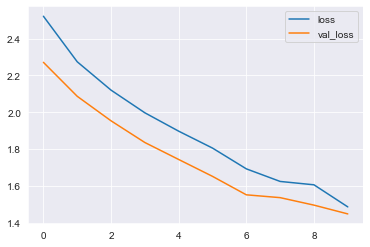

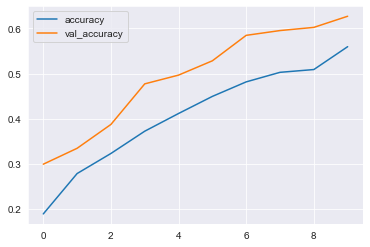

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [42]:
history2 = model.fit(xs_tmp, y_train,
                    validation_data = (xs_tmp_test, y_test),
                    epochs          = 40,
                    batch_size      = 32)

Epoch 1/40
71/71 [==============================] - 94s 1s/step - loss: 1.4341 - accuracy: 0.5739 - val_loss: 1.3899 - val_accuracy: 0.6285
Epoch 2/40
71/71 [==============================] - 81s 1s/step - loss: 1.3846 - accuracy: 0.5920 - val_loss: 1.3739 - val_accuracy: 0.6303
Epoch 3/40
71/71 [==============================] - 77s 1s/step - loss: 1.3396 - accuracy: 0.6210 - val_loss: 1.3471 - val_accuracy: 0.6620
Epoch 4/40
71/71 [==============================] - 81s 1s/step - loss: 1.2872 - accuracy: 0.6285 - val_loss: 1.3346 - val_accuracy: 0.6303
Epoch 5/40
71/71 [==============================] - 78s 1s/step - loss: 1.2922 - accuracy: 0.6180 - val_loss: 1.2983 - val_accuracy: 0.6690
Epoch 6/40
71/71 [==============================] - 81s 1s/step - loss: 1.2261 - accuracy: 0.6430 - val_loss: 1.2779 - val_accuracy: 0.6567
Epoch 7/40
71/71 [==============================] - 79s 1s/step - loss: 1.2045 - accuracy: 0.6651 - val_loss: 1.2684 - val_accuracy: 0.6919
Epoch 8/40
71/71 [==

In [43]:
#todo: confusion matrix and other 
y_pred = np.argmax(model.predict(xs_tmp_test), axis=-1)
y_true = y_test

In [44]:
pred_lists = model.predict(xs_tmp_test)
pred_df = pd.DataFrame(pred_lists, columns = categories)
pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[57,  0,  1,  6,  0,  1,  0,  1,  1,  2,  0,  0],
       [ 7, 33,  1,  0,  1,  2,  1,  0,  0,  0,  2,  0],
       [ 0,  1, 24,  5,  2,  0,  0,  3,  1,  1,  2,  0],
       [ 6,  0,  2, 32,  1,  0,  0,  0,  1,  4,  0,  0],
       [ 3,  4,  4,  0, 20,  1,  0,  0,  0,  5,  0,  1],
       [ 0,  3,  1,  0,  0, 60,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  3, 17,  0,  0,  0,  0,  0],
       [ 2,  0,  2,  0,  2,  0,  1, 36,  0,  5,  2,  1],
       [ 1,  2,  5,  6,  3,  1,  0,  0, 13,  0,  1,  0],
       [ 2,  0,  0,  0,  0,  1,  0,  4,  0, 85,  1,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  5,  1,  1, 20,  8],
       [ 2,  0,  1,  0,  3,  0,  0,  5,  0,  0,  5, 11]], dtype=int64)

In [46]:
import plotly.figure_factory as ff

z = cm

x = categories
y = categories
#y.reverse()

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion<br>matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                  yaxis=dict(autorange='reversed'),
                  title_x=0
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.26,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()